# Module 1: Chemical --> Variant

In [4]:
def chemical2variant(chemical):
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.name:' + chemical + '&fields=drugbank.pharmacology.snp_effects.effect.rs-id&dotfield=true').json()
    if doc['hits'] == 0:
        raise ValueError
    else:
        if 'drugbank.pharmacology.snp_effects.effect.rs-id' in doc['hits'][0]:
            return doc['hits'][0]['drugbank.pharmacology.snp_effects.effect.rs-id']
        

# Module 2: Variant -- > Phenotype

In [6]:
def variant2phenotype(rsid):
    doc = requests.get('http://myvariant.info/v1/variant/' + rsid + '?fields=clinvar.rcv').json()
    if 'clinvar' in doc and 'rcv' in doc['clinvar']:
        return doc['clinvar']['rcv']
    else:
        return None

# Module 3: Chemical --> Gene

In [7]:
def chemical2gene(chemical):
    result = {}
    # get target
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.name:' + chemical + '&fields=drugbank.targets.gene_name&dotfield=true').json()
    if doc['hits'] == 0:
        pass
    else:
        if 'drugbank.targets.gene_name' in doc['hits'][0]:
            result['targets'] = [_doc for _doc in doc['hits'][0]['drugbank.targets.gene_name']]
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.name:' + chemical + '&fields=drugbank.enzymes.gene_name&dotfield=true').json()
    if doc['hits'] == 0:
        pass
    else:
        if 'drugbank.enzymes.gene_name' in doc['hits'][0]:
            result['enzymes'] = [_doc for _doc in doc['hits'][0]['drugbank.enzymes.gene_name']]
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.name:' + chemical + '&fields=drugbank.enzymes.gene_name&dotfield=true').json()
    return result

In [105]:
chemical2gene('Nateglinide')

{'targets': ['ABCC8', 'PPARG'],
 'enzymes': ['CYP2C9',
  'CYP3A4',
  'CYP3A5',
  'CYP3A7',
  'PTGS1',
  'UGT1A9',
  'CYP2D6']}

# Module 4: Chemical --> Pathway

In [8]:
def chemical2pathway(chemical):
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.name:' + chemical + '&fields=drugbank.pathways.smpdb_id&dotfield=true').json()
    if doc['hits'] == 0:
        return None
    else:
        return doc['hits'][0]['drugbank.pathways.smpdb_id']

# Module 5: Pathway --> Chemical

In [9]:
def pathway2chemical(pathway):
    doc = requests.get('http://mychem.info/v1/query?q=drugbank.pathways.smpdb_id:' + pathway + '&fields=drugbank.name&dotfield=true').json()
    if doc['hits'] == 0:
        return None
    else:
        return [_doc['drugbank.name'] for _doc in doc['hits']]

# Module 6: Gene --> Variant

In [10]:
def gene2variant(gene):
    doc = requests.get('http://myvariant.info/v1/query?q=clinvar.gene.symbol:' + gene + '%20AND%20clinvar.rcv.clinical_significance:%22drug%20response%22&fields=clinvar.rsid&size=100').json()
    if doc['hits'] == 0:
        return None
    else:
        return [_doc['clinvar']['rsid'] for _doc in doc['hits']]

# Path 1: Chemical --> Variant --> Phenotype

### Step 1: Find Variants which affect drug response

In [86]:
variant = chemical2variant('codeine')
variant

['rs3892097',
 'rs5030655',
 'rs35742686',
 'rs3892097',
 'rs5030655',
 'rs1135824',
 'rs28371733']

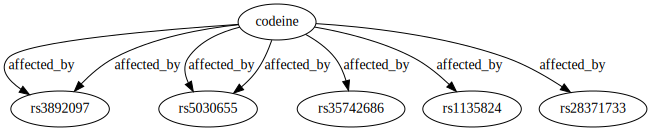

In [87]:
g = Digraph('G')
for _v in variant:
    g.edge('codeine', _v, label='affected_by')
g

### Step 2: Find phenotypes associated with variant

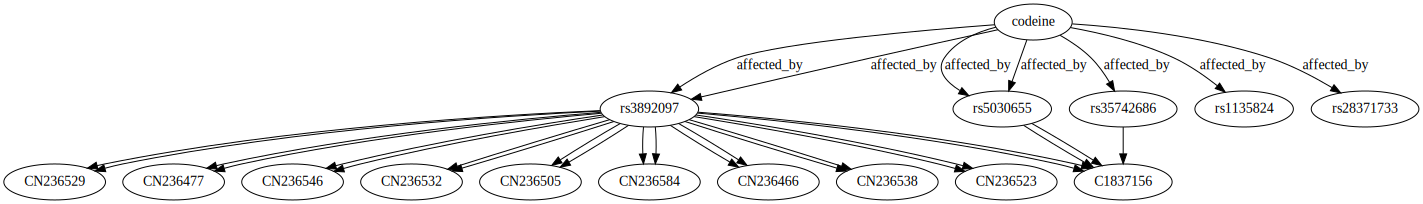

In [88]:
for _v in variant:
    phenotypes = variant2phenotype(_v)
    if phenotypes:
        for _p in phenotypes:
            if _p['clinical_significance'] == 'drug response':
                if 'conditions' in _p and 'identifiers' in _p['conditions'] and 'medgen' in _p['conditions']['identifiers']:
                    g.edge(_v, _p['conditions']['identifiers']['medgen'])
g

# Path2: Chemical --> Gene --> Variant --> Phenotype

### Step 1: Find genes that metabolize/targeted by chemical

In [89]:
gene = chemical2gene('codeine')
gene

{'targets': ['OPRM1', 'OPRK1', 'OPRD1'],
 'enzymes': ['CYP2D6',
  'CYP3A4',
  'CYP3A5',
  'CYP3A7',
  'UGT2B7',
  'UGT2B4',
  'UGT1A1']}

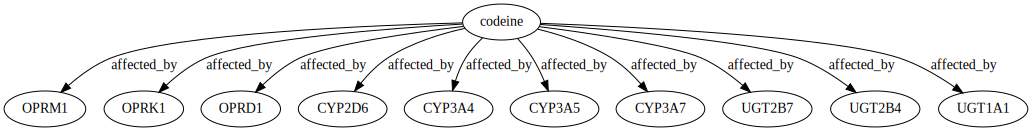

In [93]:
g = Digraph('G')


for k, v in gene.items():
    for _v in v:
        g.edge('codeine', _v, label='affected_by')

g

### Step 2: Find variants located on specific genes which affect drug response

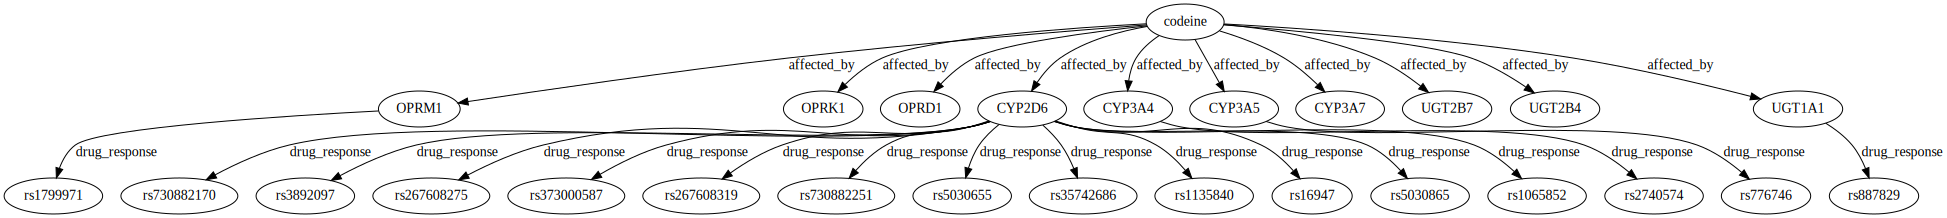

In [94]:
variants = []
for k, v in gene.items():
    for _v in v:
        variant = gene2variant(_v)
        if variant:
            for _vv in variant:
                g.edge(_v, _vv, label='drug_response')
                variants.append(_vv)

g

### Find phenotypes associated with variant

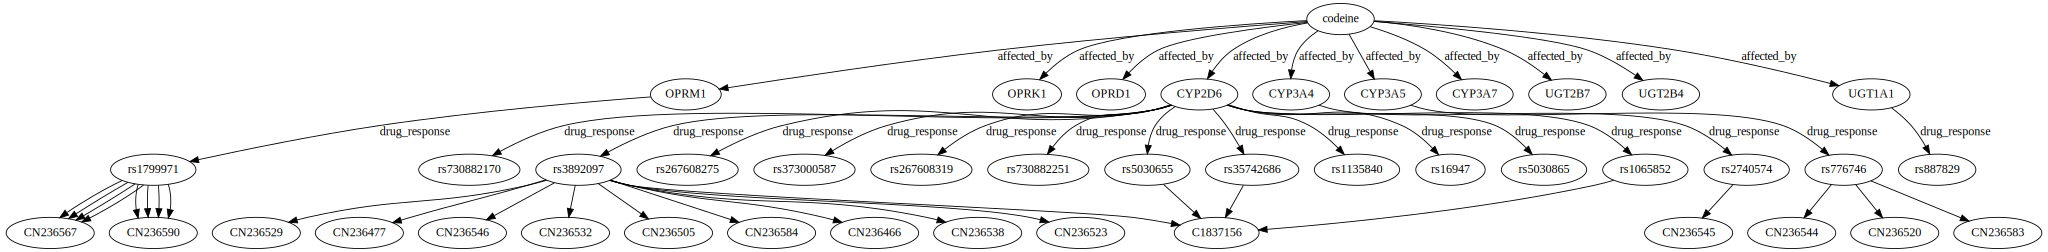

In [98]:
for _v in variants:
    phenotypes = variant2phenotype(_v)
    if phenotypes:
        for _p in phenotypes:
            if type(_p) == dict and _p['clinical_significance'] == 'drug response':
                if 'conditions' in _p and 'identifiers' in _p['conditions'] and 'medgen' in _p['conditions']['identifiers']:
                    g.edge(_v, _p['conditions']['identifiers']['medgen'])
g

# Path 3: Chemical --> Pathway --> Chemical --> Gene --> Variant --> Phenotype

### Step 1: Find SMPDB pathway a chemical is involved

In [23]:
pathway = chemical2pathway('codeine')

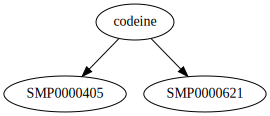

In [57]:
g = Digraph('G')
for _p in pathway:
    g.edge('codeine', _p)
g

In [58]:
pathway

['SMP0000405', 'SMP0000621']

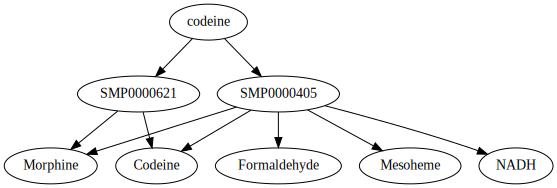

In [59]:
chemical_list = []
for _p in pathway:
    chemical_list = pathway2chemical(_p)
    for _c in chemical_list:
        g.edge(_p, _c)
g    

In [60]:
chemical_list = ['Codeine', 'Formaldehyde', 'Mesoheme', 'Morphine']

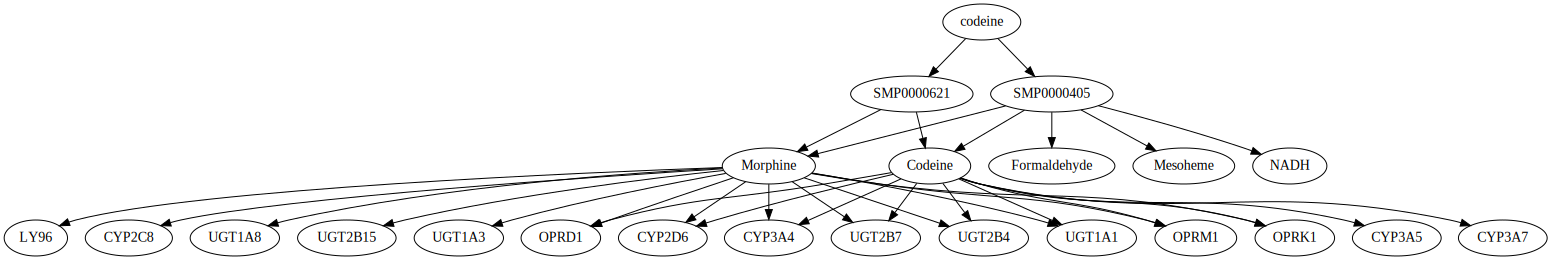

In [61]:
gene_list_full = set()
for _c in chemical_list:
    gene_list = chemical2gene(_c)
    for k, v in gene_list.items():
        if v:
            for _v in v:
                g.edge(_c, _v)
                gene_list_full.add(_v)
g

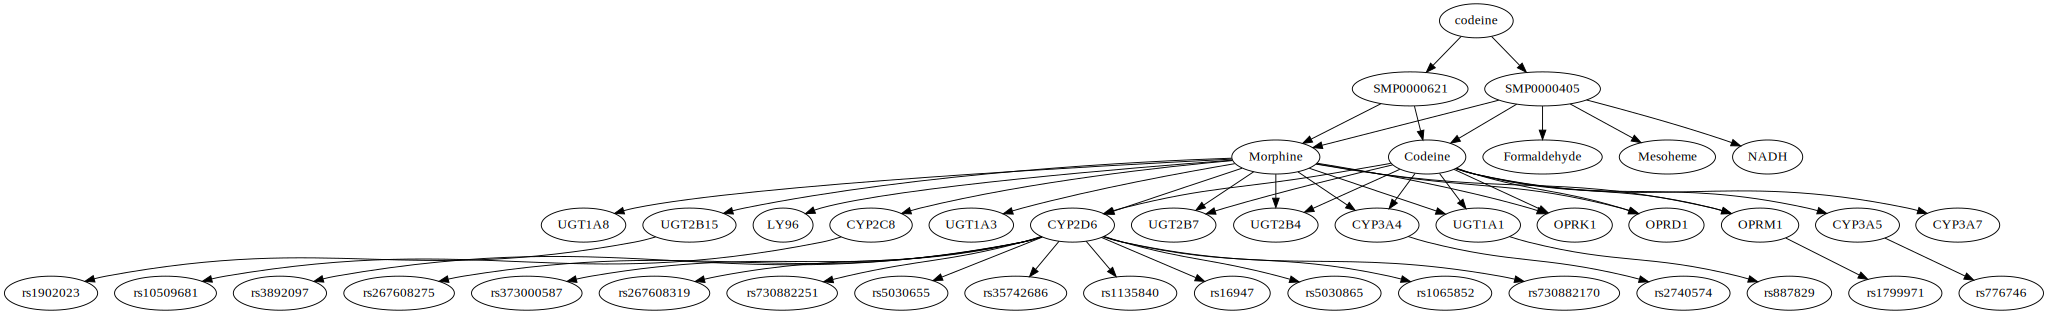

In [63]:
for _g in gene_list_full:
    variant = gene2variant(_g)
    if variant:
        for _v in variant:
            g.edge(_g, _v)
g

# Path 4: Chemical --> Pathway --> Chemical --> Variant --> Phenotype

In [100]:
pathway = chemical2pathway('codeine')

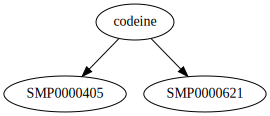

In [101]:
g = Digraph('G')
for _p in pathway:
    g.edge('codeine', _p)
g

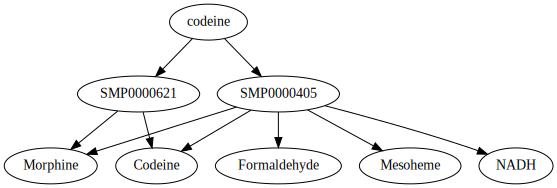

In [102]:
chemical_list = []
for _p in pathway:
    chemical_list = pathway2chemical(_p)
    for _c in chemical_list:
        g.edge(_p, _c)
g    

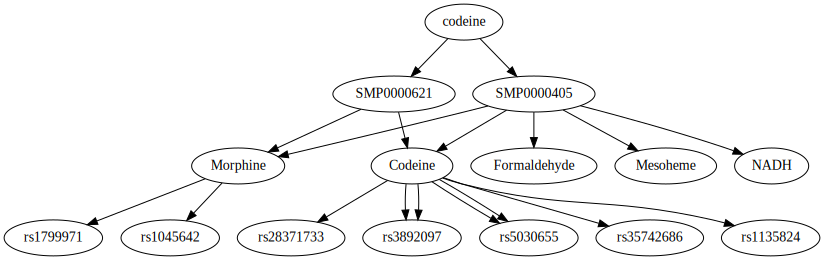

In [103]:
variants = []
for _c in set(chemical_list):
    variant_list = chemical2variant(_c)
    if variant_list:
        for _v in variant_list:
            g.edge(_c, _v)
            variants.append(_v)
g

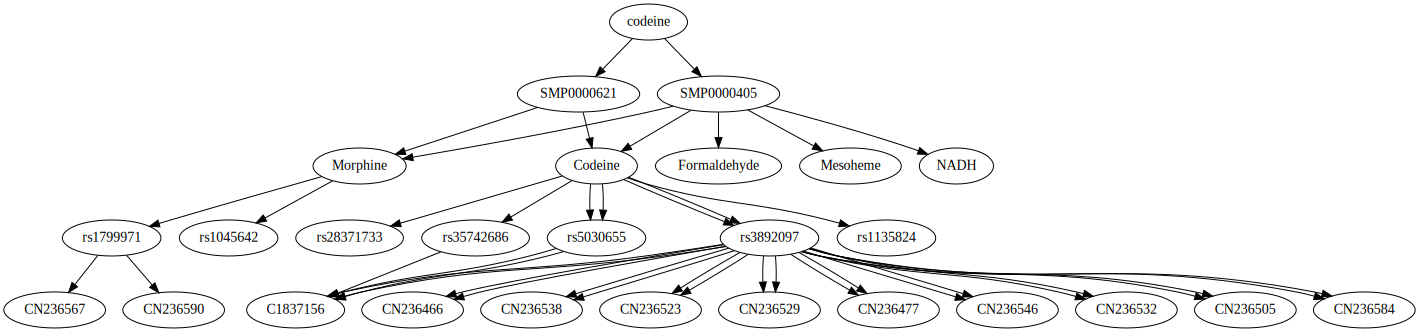

In [104]:
for _v in variants:
    phenotypes = variant2phenotype(_v)
    if phenotypes:
        for _p in phenotypes:
            if type(_p) == dict and _p['clinical_significance'] == 'drug response':
                if 'conditions' in _p and 'identifiers' in _p['conditions'] and 'medgen' in _p['conditions']['identifiers']:
                    g.edge(_v, _p['conditions']['identifiers']['medgen'])
g